# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project2: Build a Traffic Sign Recognition Classifier

This is the code and writeup for Udacity Self Driving Nano Degree Term 1 Project 2. 




---
## Step 0: Load The Data

In [1]:
import requests, zipfile, io
import os
import pickle

import pandas as pd
import numpy as np
import tensorflow as tf

data_path = os.path.expanduser('~/data')

In [3]:
# Download the dataset

! mkdir ~/data
zip_file_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=data_path)

In [79]:
# Load dataset

training_file = os.path.join(data_path,'train.p')
validation_file= os.path.join(data_path,'valid.p')
testing_file = os.path.join(data_path,'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
random_seed = 40
X_train, y_train = train['features'], train['labels']

In [6]:
np.random.seed(random_seed)
np.random.shuffle(X_train)

np.random.seed(random_seed)
np.random.shuffle(y_train)

X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### A Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
n_train = X_train.shape[0] #training examples
n_test = X_test.shape[0]  #testing examples
image_shape = X_test[0].shape #image size (32x32x1)

#unique classes/labels there are in the dataset.
y_df = pd.DataFrame(y_test)
n_classes = len(y_df[0].unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

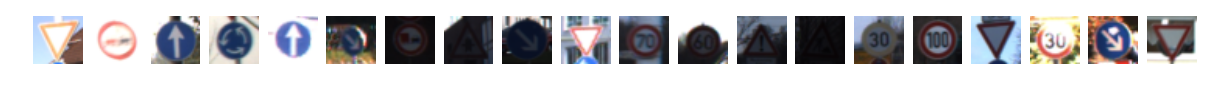

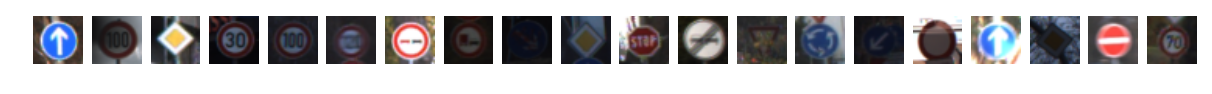

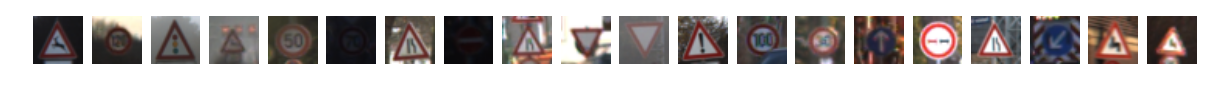

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

#helper function to show several images
def show_imgs(img_arr, cmap=None):
    
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):
        ax[i].imshow(img, cmap=cmap)

show_imgs(X_train[:20])
show_imgs(X_train[100:120])
show_imgs(X_train[2000:2020])


The above images is an exploratoratory visualization showing the types of images that are contained in this dataset.

----

## A Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

Here I normalize the images so that no one image is too bright or dark that would confuse the classifer. This puts the pixel values between -1 and 1 instead of 0 and 255 which makes it easier for the neural network to intialize weights and minimize error.

I chose not to augment the dataset.

In [11]:
import numpy as np

def norm_image(img):
    return (img - img.mean() / np.std(img))/255.0

X_train_norm = np.array([norm_image(i) for i in X_train])
X_valid_norm = np.array([(i - i.mean() / np.std(i))/255.0 for i in X_valid])
X_test_norm = np.array([(i - i.mean() / np.std(i))/255.0 for i in X_test])

### Model Architecture

I ended up designing a neural net that uses 4 Convolution layers and a single dense layer. Each layer uses a RELU activation except the last layer which uses a softmax activation to categorize the output. 

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def net2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    conv1_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)

    conv4_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 128, 512), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(512))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4 = tf.nn.relu(conv4)
    
    fc0   = flatten(conv4)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits    = tf.matmul(fc0, fc2_W) + fc2_b

    return logits


### Train, Validate and Test the Model

To train the model I used back propigation to minimize the cross entropy error of the output classifications.

After each epoch of training the entire validation set was evauated and the average error is printed. 

The initial archetecture was the standard LeNet model with no image normalization. To improve performance I reduced the number of dense nurons and changed the kernal size of the convolution layers. This was enough to get above the needed accuracy threshold. 

In [80]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,43)

BATCH_SIZE = 128
EPOCHS = 15

# Define loss and optimizer

learning_rate = .001
logits = net2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(cost)

correct_prediction = tf.equal(tf.arg_max(logits, 1), tf.arg_max(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
def evaluate(X_data, Y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset: offset+BATCH_SIZE], Y_data[offset: offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
import math
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, "/tmp/model2.ckpt")

    # Training cycle
    for epoch in range(EPOCHS):
        
        # Loop over all batches
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            x_batch, y_batch = X_train_norm[offset:end], y_train[offset: end]
        
            #print('b', end=' ')
            #x_batch, y_batch = next_batch(BATCH_SIZE, X_train_norm, y_train)
            #print('t', end=' ')
            sess.run(
                training_operation,
                feed_dict={x: x_batch, y: y_batch})

        valid_accuracy = evaluate(X_valid_norm, y_valid, sess)
        print('Epoch {:<3} - Validation Accuracy: {}'.format(
            epoch,
            valid_accuracy))
    
    test_accuracy = evaluate(X_test_norm, y_test, sess)
    print('Test Accuracy: {}'.format(test_accuracy))
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    # Save the model
    saver.save(sess, '/tmp/model2.ckpt')
    print('Trained Model Saved.')


Epoch 0   - Validation Accuracy: 0.8845804981363603
Epoch 1   - Validation Accuracy: 0.9253968257212044
Epoch 2   - Validation Accuracy: 0.9287981857247904
Epoch 3   - Validation Accuracy: 0.9383219952756315
Epoch 4   - Validation Accuracy: 0.9274376415071033
Epoch 5   - Validation Accuracy: 0.9473922900331804
Epoch 6   - Validation Accuracy: 0.9546485263474134
Epoch 7   - Validation Accuracy: 0.9414965989097717
Epoch 8   - Validation Accuracy: 0.95578231292517
Epoch 9   - Validation Accuracy: 0.9537414963823868
Epoch 10  - Validation Accuracy: 0.9451247163640669
Epoch 11  - Validation Accuracy: 0.9541950109053631
Epoch 12  - Validation Accuracy: 0.945804988175563
Epoch 13  - Validation Accuracy: 0.9625850342839213
Epoch 14  - Validation Accuracy: 0.940816325503412
Test Accuracy: 0.9323832142664531
Trained Model Saved.


In [18]:
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, "/tmp/model2.ckpt")
    test_accuracy = evaluate(X_test_norm, y_test, sess)
    print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9323832142664531


---

## Test a Model on New Images

To test the utility of the network I downloaded additional sign images from the web and classified them with the network. Only 50% of the signs were classified accurately. This is likely due to the inconsistency of the image quality and some watermarks that were included in the images.

### Load and Output the Images

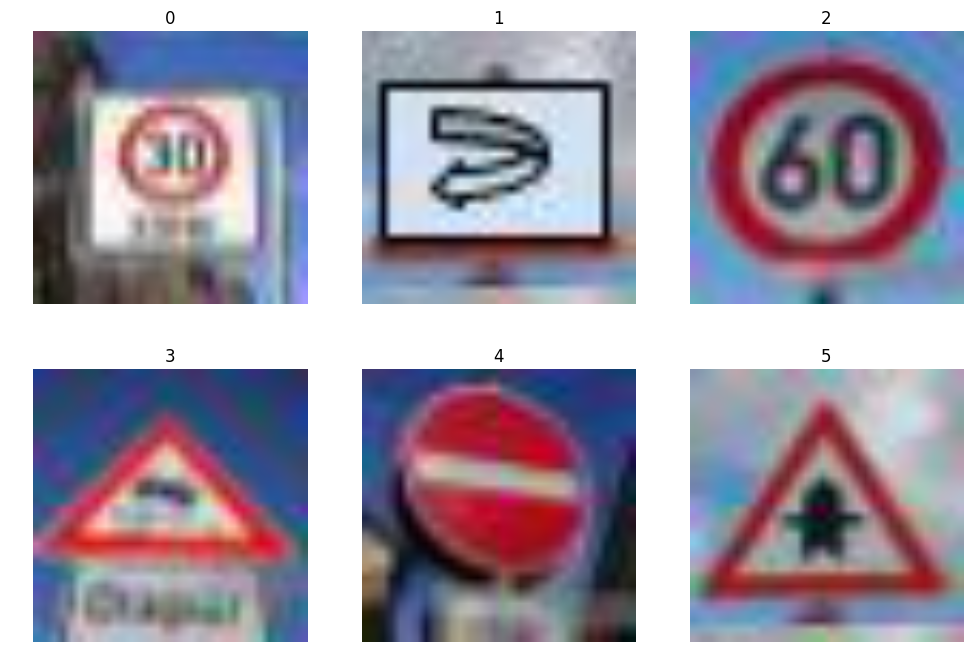

In [72]:
### Load the images and plot them here.
import csv, glob

#Import traffic signs class names
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

#Import new sign images  
test_img_paths = [img_path for img_path in glob.glob("./new_signs/*")]
test_img=np.uint8(np.zeros((6,32,32,3)))
test_img_norm=np.zeros((6,32,32,3), dtype=float)
for i, imp in enumerate(test_img_paths):
    img=PIL.Image.open(imp)
    test_img[i]=np.array(img)
    test_img_norm[i] = norm_image(np.array(img))

#Visualize sign images
num_of_samples = []
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_img[i]) 
    plt.title(i)
    plt.axis('off')
plt.show()

### Predict the Sign Type for Each Image

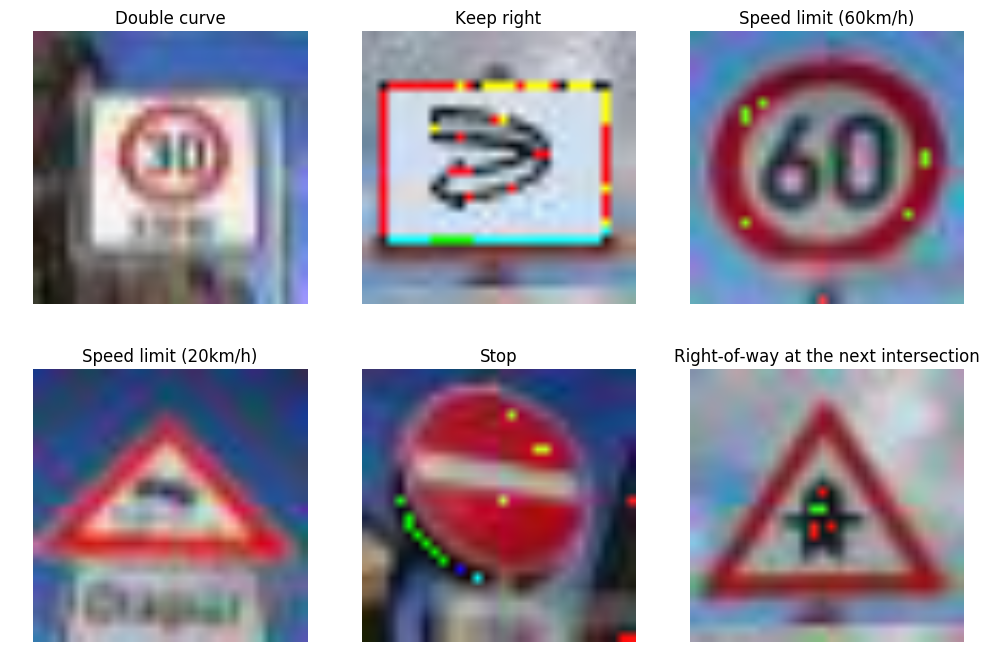

In [76]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def test_net(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data})
    return pred_sign

with tf.Session() as sess:
    saver.restore(sess, '/tmp/model2.ckpt')
    signs_classes=test_net(test_img_norm, sess)

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_img_norm[i]) 
    plt.title(signs_class[signs_classes[i]])
    plt.axis('off')
plt.show()

### Analyze Performance

The predictions returned 3 of 6 correctly or 50%. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Below I show the softmax outputs of the image classification to help show how certain the classifier is with the output. 

One of the incorrect classifications shows a distibution showing that it's unsure. However none of the top 5 choices is the correct answer. This is likely due to the pixelation or scale of the image. This could be overcome by augmenting the training data.

The other 2 incorrect classifications show that the model is very confident with it's prediction. This could be due to there not being a similar image in the training dataset. 

In [77]:
def test_net(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)


with tf.Session() as sess:
    saver.restore(sess, '/tmp/model2.ckpt')
    signs_top_5=test_net(test_img_norm, sess)

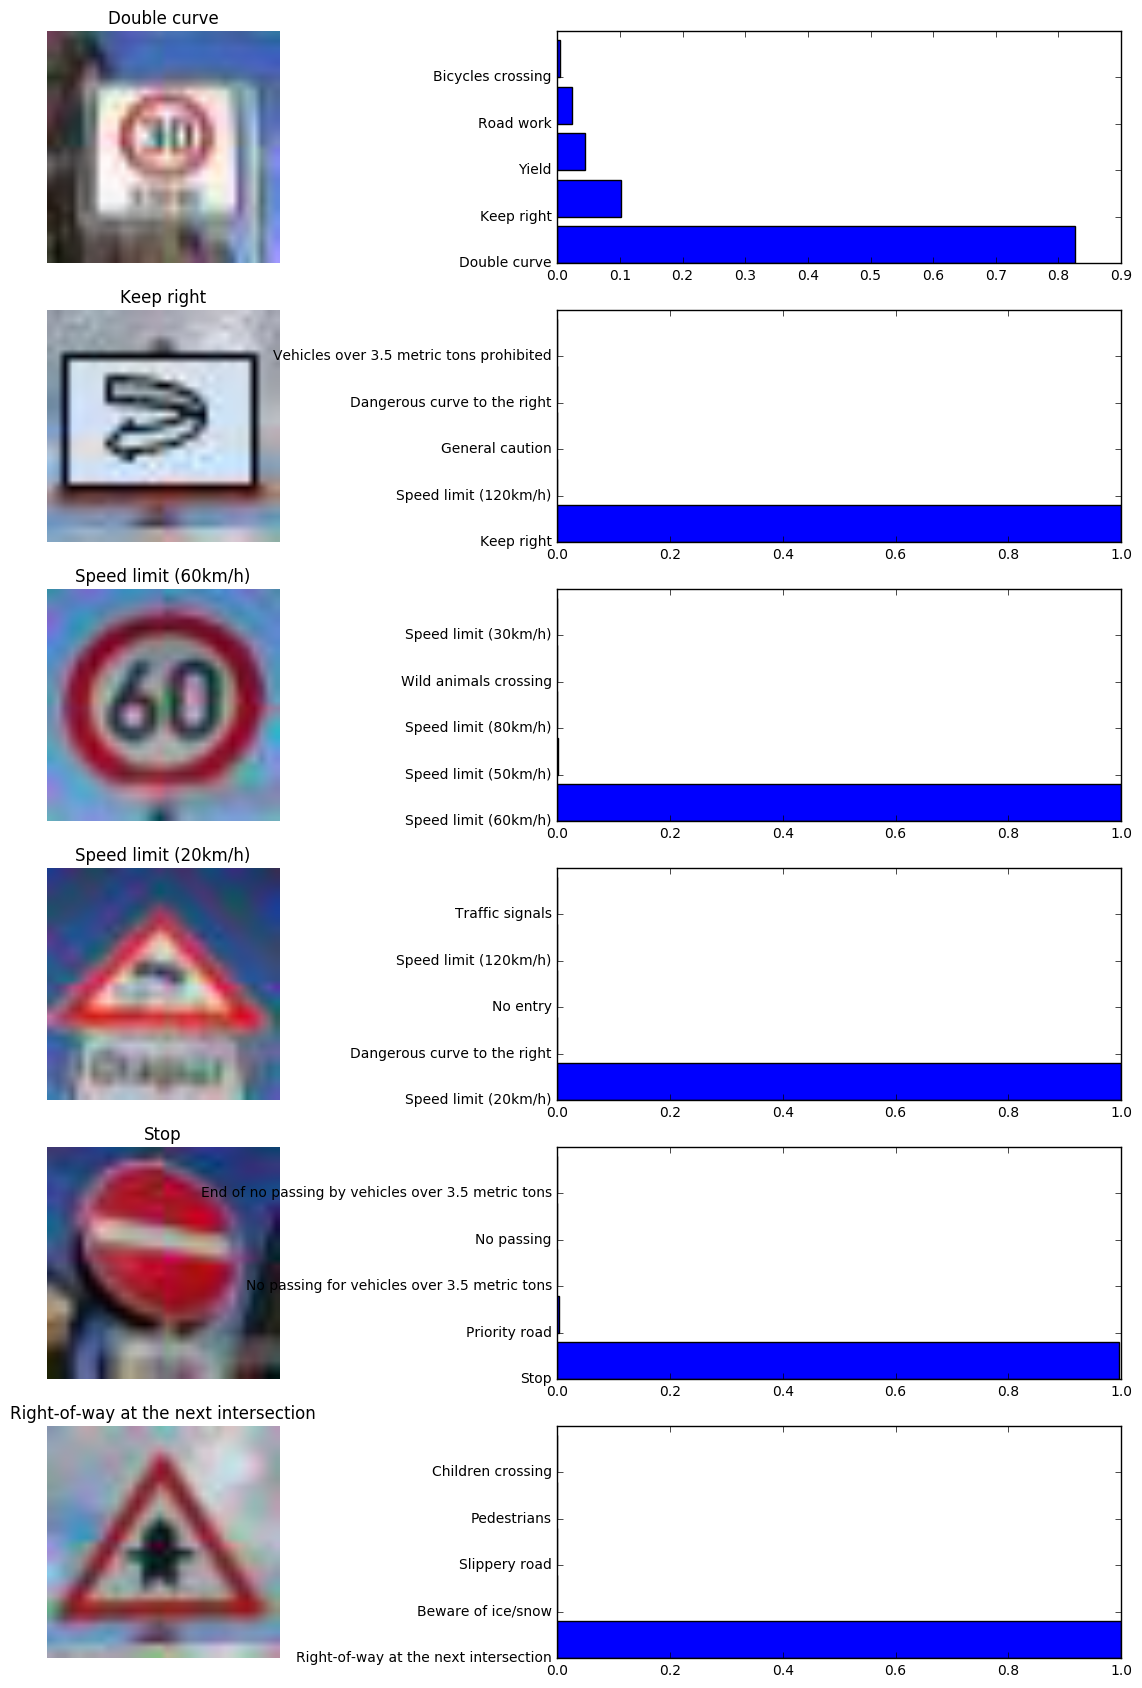

In [78]:
plt.figure(figsize=(16, 21))
for i in range(6):
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(test_img[i]) 
    plt.title(signs_class[signs_classes[i]])
    plt.axis('off')
    plt.subplot(6, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), signs_top_5.values[i, :])
    lables=[signs_class[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), lables)
plt.show()

### This document contains the code & writeup for this project.